In [1]:
import pandas as pd
from datetime import timedelta
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import pickle
import os
## Project import #
from tfib.evaluations import nDCG_loss
from tfib.evaluations import network_dismantle
from tfib.utils import make_lists_same_length
from tfib.utils import plot_grid_search_heatmap
from tfib.utils import plot_dismantling_graph
from tfib.tfibengines import TFIBEngine

In [2]:
# SETTINGS #

DATASET_PATH = "data/COVID19_2023_02_22_DATASET.csv"
TRAIN_SPLIT = 0.8 # 0.3
VALID_SPLIT = 0.2 # 0.2
CREDIBILITY_THR = 35.0
USE_ORIGINAL_RTT = True
PARALLELIZATION_ENABLED = True
N_JOBS = os.cpu_count()

## Data load and split

In [3]:
dtype = {'tweet_id': str,
         'user_id': str,
         'retweeted_user_id': str,
         'retweeted_status_id': str,
         "retweeeted_user_id": str}

covid_df = pd.read_csv(DATASET_PATH, parse_dates=[1], dtype=dtype)

In [4]:
covid_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,ORIGIN,AUTHOR,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,ORIGIN,AUTHOR,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,ORIGIN,AUTHOR,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,ORIGIN,AUTHOR,95.0
...,...,...,...,...,...,...
819947,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,1450461737895989261,4758512368,39.5
819948,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1451536139131801605,1446561632105205774,82.5
819949,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1451310094461947909,1173682089637625856,12.5
819950,1451536327388942348,2021-10-22 13:10:03+00:00,1036611673,1451536158098399236,1260895357548068865,20.0


In [5]:
data_df = covid_df[covid_df.retweeted_user_id != "AUTHOR"].sort_values(by="created_at").reset_index(drop=True)
data_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,2020-12-20 02:12:36+00:00,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,2020-12-20 02:16:09+00:00,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,2020-12-20 02:17:58+00:00,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,2020-12-20 02:48:39+00:00,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
371581,1451535612004216833,2021-10-22 13:07:12+00:00,1430162268,1451523072146743324,605614784,80.0
371582,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,1450461737895989261,4758512368,39.5
371583,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1451536139131801605,1446561632105205774,82.5
371584,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1451310094461947909,1173682089637625856,12.5


In [6]:
# Splits
cut_index = int(len(data_df)*TRAIN_SPLIT)
train_set_df = data_df.iloc[:cut_index]
test_set_df = data_df.iloc[cut_index:]

In [7]:
train_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,2020-12-20 02:12:36+00:00,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,2020-12-20 02:16:09+00:00,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,2020-12-20 02:17:58+00:00,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,2020-12-20 02:48:39+00:00,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
297263,1432778805035290626,2021-08-31 18:54:21+00:00,1418645210645549056,1432687159715246081,283416650,82.5
297264,1432778912120049667,2021-08-31 18:54:47+00:00,1416832693136990210,1432773436250759169,454909771,17.5
297265,1432778969896660993,2021-08-31 18:55:00+00:00,385897719,1432617915908509697,25676606,75.0
297266,1432779018085019649,2021-08-31 18:55:12+00:00,225168723,856536268251025411,289400495,77.5


In [8]:
test_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
297268,1432779497368170499,2021-08-31 18:57:06+00:00,1039518696476045312,1432777108896555008,1144560202529812480,87.5
297269,1432779808866439168,2021-08-31 18:58:20+00:00,1385709282,1432732377311232004,1032615842,0.0
297270,1432779983995428865,2021-08-31 18:59:02+00:00,2397689598,1432739257731403776,4758512368,39.5
297271,1432780137481838595,2021-08-31 18:59:39+00:00,139765259,1432332225077514244,4758512368,39.5
297272,1432780414817611780,2021-08-31 19:00:45+00:00,355402185,1432685864346439688,25676606,75.0
...,...,...,...,...,...,...
371581,1451535612004216833,2021-10-22 13:07:12+00:00,1430162268,1451523072146743324,605614784,80.0
371582,1451536212381011970,2021-10-22 13:09:35+00:00,1329549977463508993,1450461737895989261,4758512368,39.5
371583,1451536215858155528,2021-10-22 13:09:36+00:00,1446561632105205774,1451536139131801605,1446561632105205774,82.5
371584,1451536226876526601,2021-10-22 13:09:39+00:00,712365073,1451310094461947909,1173682089637625856,12.5


## Tuning and Validation Split

- The model will be trained repeatedly on a Tuning set == Training set - Validation set
- The model will be evaluated each time on the same Validation set

In [9]:
# Split the train set in Tuning and Validation Set
cut_index = int(len(train_set_df)*(1-VALID_SPLIT))
tuning_set_df = train_set_df.iloc[:cut_index]
valid_set_df = train_set_df.iloc[cut_index:]

In [10]:
tuning_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1340325850378592257,1017807360075665408,64.5
1,1340480189462134784,2020-12-20 02:12:36+00:00,2288557992,1340427316573462530,1063806444380798976,95.0
2,1340481082270085120,2020-12-20 02:16:09+00:00,1237071348662448129,1340427316573462530,1063806444380798976,95.0
3,1340481539709276163,2020-12-20 02:17:58+00:00,475234937,1340481328056332289,122733775,90.0
4,1340489259183206406,2020-12-20 02:48:39+00:00,100878763,1340427316573462530,1063806444380798976,95.0
...,...,...,...,...,...,...
237809,1417745910134624256,2021-07-21 07:19:00+00:00,759428777793429505,1417735563629801475,1683455144,5.0
237810,1417745974055866369,2021-07-21 07:19:15+00:00,1027756003134263296,1417518076795437057,1032615842,25.0
237811,1417746154217934850,2021-07-21 07:19:58+00:00,707207821,1417602406326616071,1165229956122763265,17.5
237812,1417746610759651329,2021-07-21 07:21:47+00:00,405179576,1417740978413318144,1072167411984551936,100.0


In [11]:
valid_set_df

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
237814,1417746832109838337,2021-07-21 07:22:39+00:00,3163728767,1417574650650009603,25676606,75.0
237815,1417747134636609538,2021-07-21 07:23:52+00:00,1167004816603828224,1417740978413318144,1072167411984551936,100.0
237816,1417747156916744192,2021-07-21 07:23:57+00:00,1367792634199162885,1417744249613869058,1032615842,95.0
237817,1417747542037733377,2021-07-21 07:25:29+00:00,1103360481341902854,1400423583575379970,331617619,82.5
237818,1417747652045852674,2021-07-21 07:25:55+00:00,869873746559062017,1417747360080334848,257130763,87.5
...,...,...,...,...,...,...
297263,1432778805035290626,2021-08-31 18:54:21+00:00,1418645210645549056,1432687159715246081,283416650,82.5
297264,1432778912120049667,2021-08-31 18:54:47+00:00,1416832693136990210,1432773436250759169,454909771,17.5
297265,1432778969896660993,2021-08-31 18:55:00+00:00,385897719,1432617915908509697,25676606,75.0
297266,1432779018085019649,2021-08-31 18:55:12+00:00,225168723,856536268251025411,289400495,77.5


In [12]:
# Prepare data for hyper-parameter tuning
tuning_set = list(tuning_set_df.itertuples(index=False))

In [13]:
# Validation ground truth loading
from tfib.evaluations import get_retweet_network, get_optimal_ranking

# Validation retweet network
validation_retweets_network = get_retweet_network(
    valid_set_df[valid_set_df.credibility_score <= CREDIBILITY_THR],
    rt_UserID_col="retweeted_user_id",
    userID_col="user_id",
    rating_col="credibility_score")

# Validation optimal ranking
validation_optimal_ranking = get_optimal_ranking(validation_retweets_network).set_index("node")
validation_optimal_ranking

,outgoing_weight,incoming_weight
node,,
1683455144,3970.0,10.0
1248216384577953792,1226.0,9.0
1032615842,1151.0,65.0
245969509,732.0,20.0
454365633,557.0,1.0
...,...,...
995833592671490050,0.0,1.0
99702635,0.0,1.0
998516845241159683,0.0,1.0


In [14]:
# Assign a combined single score to the ranking that keeps the order
validation_optimal_ranking['combined'] = (
    validation_optimal_ranking["outgoing_weight"] +
    validation_optimal_ranking["incoming_weight"] / 
    (validation_optimal_ranking["incoming_weight"].max() + 1))

validation_optimal_ranking

,outgoing_weight,incoming_weight,combined
node,,,
1683455144,3970.0,10.0,3970.090090
1248216384577953792,1226.0,9.0,1226.081081
1032615842,1151.0,65.0,1151.585586
245969509,732.0,20.0,732.180180
454365633,557.0,1.0,557.009009
...,...,...,...
995833592671490050,0.0,1.0,0.009009
99702635,0.0,1.0,0.009009
998516845241159683,0.0,1.0,0.009009


In [15]:
# Create the ranking in the dict format
validation_optimal_ranking = validation_optimal_ranking.to_dict()["combined"]
list(validation_optimal_ranking.items())[:10]

[('1683455144', 3970.09009009009),
 ('1248216384577953792', 1226.081081081081),
 ('1032615842', 1151.5855855855855),
 ('245969509', 732.1801801801802),
 ('454365633', 557.009009009009),
 ('337767301', 423.0),
 ('598157014', 337.0),
 ('1289758279250452480', 326.009009009009),
 ('221681749', 291.0900900900901),
 ('500882938', 267.009009009009)]

## Hyperparameters Tuning (Grid search)

In [16]:
# Alpha values to explore (importance of the past activity against the last)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Beta values to explore (Activity deviation sensitivity)
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Gamma values to explore
gammas = [4.0, 2.0, 1.0, 0.0]

# Delta values to explore (Days interval)
max_days = (tuning_set_df.created_at.max() - tuning_set_df.created_at.min()).days
deltas = list(range(1, 32)) + [max_days]

# if standard method is used
if USE_ORIGINAL_RTT:
    # disable beta and gamma
    betas, gammas = [-1], [-1]

# Build hyperparameters configuration set
hparams_set = []
for a in alphas:    
    for b in betas:
        for g in gammas:
            for d in deltas:
                hparams_set.append((a, b, g, d))

# Results storage
evaluated_hparams = []

# Total configurations to test
print(f"Testing {len(hparams_set)} configurations...")

# Kernel function
def test_config(alpha, beta, gamma, delta):

    # create a new model instance with params
    engine = TFIBEngine(
        reshare_key=lambda x: x[0],
        author_key=lambda x: x[2],
        original_post_key=lambda x: x[3],
        original_author_key=lambda x: x[4],
        timestamp_key=lambda x: x[1],
        flag_key=lambda x: x[5],
        credibility_threshold = CREDIBILITY_THR,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        delta=timedelta(days=delta),
        use_original_rtt=USE_ORIGINAL_RTT,
        enable_repost_count_scaling=False)

    # fit the model
    engine.time_fit(tuning_set)

    # get the rank
    ranking = engine.get_rank()
    
    # ranking evaluation
    loss = nDCG_loss(validation_optimal_ranking, ranking)

    return (alpha, beta, gamma, delta, loss)


# run grid search
if PARALLELIZATION_ENABLED:
    # run in parallel...
    evaluated_hparams = Parallel(n_jobs=N_JOBS, prefer="processes", verbose=10)(delayed(test_config)(*hparams) for hparams in hparams_set)
else:
    # ...otherwise run serialized
    for hparams in tqdm(hparams_set):
        evaluated_hparams.append(test_config(*hparams))

Testing 320 configurations...


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:    9.9s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:   18.3s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:   38.7s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:   48.9s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:  1.0min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:  1.3min
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:  1.5min
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:  2.0min
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:  2.2min
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  2.5min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  2.8min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  3.1min
[Parallel(n_jobs=32)]: Done 290 out of 320 | elapsed:  

In [17]:
# Create a dataframe for evaluated combinations
evaluated_hparams_df = pd.DataFrame(evaluated_hparams,
                                    columns=["Alpha", "Beta", "Gamma", "Delta", "Loss"]).sort_values(by=["Loss", "Delta"])

evaluated_hparams_df.reset_index(inplace=True, drop=True)

evaluated_hparams_df.head(10)

,Alpha,Beta,Gamma,Delta,Loss
0,0.4,-1,-1,21,0.057719
1,0.2,-1,-1,28,0.058345
2,0.6,-1,-1,29,0.058462
3,0.5,-1,-1,29,0.058645
4,0.5,-1,-1,16,0.058802
5,0.5,-1,-1,14,0.058970
6,0.4,-1,-1,28,0.059325
7,0.4,-1,-1,29,0.059332
8,0.5,-1,-1,28,0.059360
9,0.2,-1,-1,24,0.059370


## Visualize grid search results

In [18]:
# Take the best values
v_alpha, v_beta, v_gamma, v_delta = list(evaluated_hparams_df.iloc[0].values)[:-1]

# Create a new model instance with params
valid_engine = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=v_alpha,
    beta=v_beta,
    gamma=v_gamma,
    delta=timedelta(days=v_delta),
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

valid_engine.time_fit(tuning_set)
v_ranking = valid_engine.get_rank()

In [19]:
# Generate the dismantling tracks
v_dismantled_true = network_dismantle(validation_retweets_network, validation_optimal_ranking)
v_dismantled_test = network_dismantle(validation_retweets_network, v_ranking)

# Build the validation dismantling dataframe with results
v_dismantled_df = {}
v_dismantled_df["Validation optimal"] = [x[1] for x in v_dismantled_true]
v_dismantled_df["Validation test"] = [x[1] for x in v_dismantled_test]
make_lists_same_length(v_dismantled_df)
v_dismantled_df = pd.DataFrame.from_dict(v_dismantled_df)

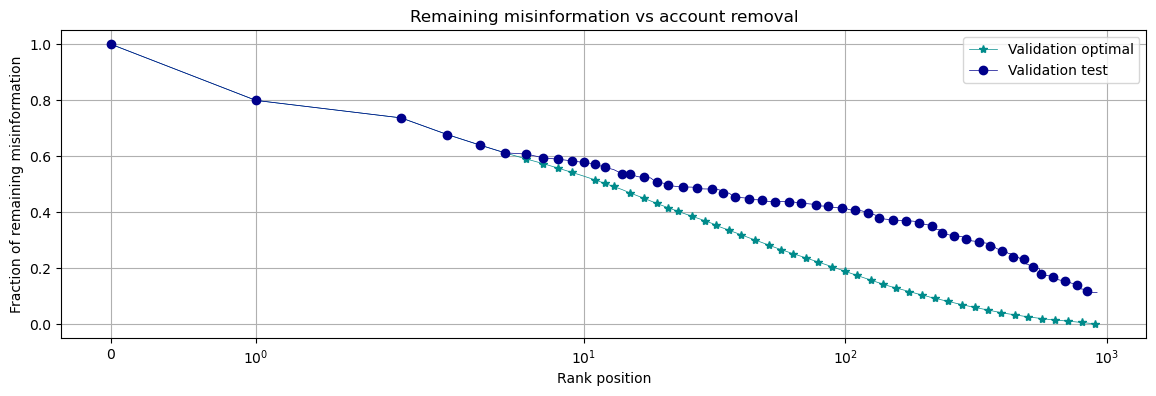

In [20]:
plot_dismantling_graph(v_dismantled_df, ["darkcyan", "darkblue"], ["*-", "o-"])

### Grid Search Plotting

In [21]:
# Group by 'Alpha' and 'Delta', then find the row(s) with max 'Loss' in each group
min_loss_rows = evaluated_hparams_df.loc[evaluated_hparams_df.groupby(['Alpha', 'Delta'])['Loss'].idxmin()]

# Pivot the DataFrame
grid_search_df = min_loss_rows.pivot(index='Alpha', columns='Delta', values='Loss')

# Reorder rows and columns in ascending order
grid_search_df.sort_index(axis=0, inplace=True, ascending=False)
grid_search_df.sort_index(axis=1, inplace=True)

In [22]:
grid_search_df

Delta,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,213
Alpha,,,,,,,,,,,,,,,,,,,,,
1.0,0.540083,0.331684,0.178435,0.179882,0.184326,0.195822,0.163174,0.139534,0.149438,0.139874,...,0.101751,0.107830,0.107503,0.100256,0.093783,0.094373,0.105940,0.094033,0.102510,0.070692
0.9,0.153475,0.095410,0.084761,0.078711,0.079281,0.070013,0.069719,0.066123,0.071654,0.073676,...,0.072097,0.074124,0.074364,0.075344,0.073101,0.076310,0.074737,0.076508,0.074925,0.070712
0.8,0.138717,0.088803,0.079179,0.076327,0.072260,0.068363,0.066958,0.064970,0.064866,0.072484,...,0.067750,0.068840,0.068273,0.068517,0.067487,0.068738,0.067493,0.068433,0.068007,0.070712
0.7,0.263467,0.088810,0.077301,0.079286,0.073616,0.068466,0.068118,0.064320,0.065263,0.064386,...,0.067382,0.067891,0.067385,0.067568,0.066444,0.067664,0.067003,0.066324,0.066671,0.070712
0.6,0.261884,0.093143,0.079991,0.084575,0.074481,0.070886,0.065441,0.062508,0.063770,0.066193,...,0.059913,0.067497,0.067016,0.059957,0.066866,0.067093,0.058462,0.066292,0.066991,0.070712
0.5,0.309541,0.095335,0.083083,0.092445,0.074190,0.073351,0.070979,0.065248,0.064452,0.065246,...,0.061256,0.059970,0.068089,0.061834,0.067571,0.059360,0.058645,0.067446,0.068275,0.070730
0.4,0.327127,0.097105,0.084666,0.097151,0.077646,0.077179,0.071608,0.069275,0.069050,0.066927,...,0.059658,0.060736,0.060458,0.060055,0.060436,0.059325,0.059332,0.060959,0.069287,0.070633
0.3,0.332797,0.107890,0.086545,0.099383,0.080237,0.080225,0.077813,0.070825,0.071327,0.073620,...,0.062827,0.062376,0.062967,0.062897,0.062421,0.060253,0.060522,0.061797,0.062932,0.071089
0.2,0.333542,0.107938,0.218823,0.106987,0.081255,0.081060,0.079283,0.074803,0.071647,0.077380,...,0.066359,0.059370,0.061522,0.067597,0.060334,0.058345,0.060124,0.066741,0.065070,0.071352


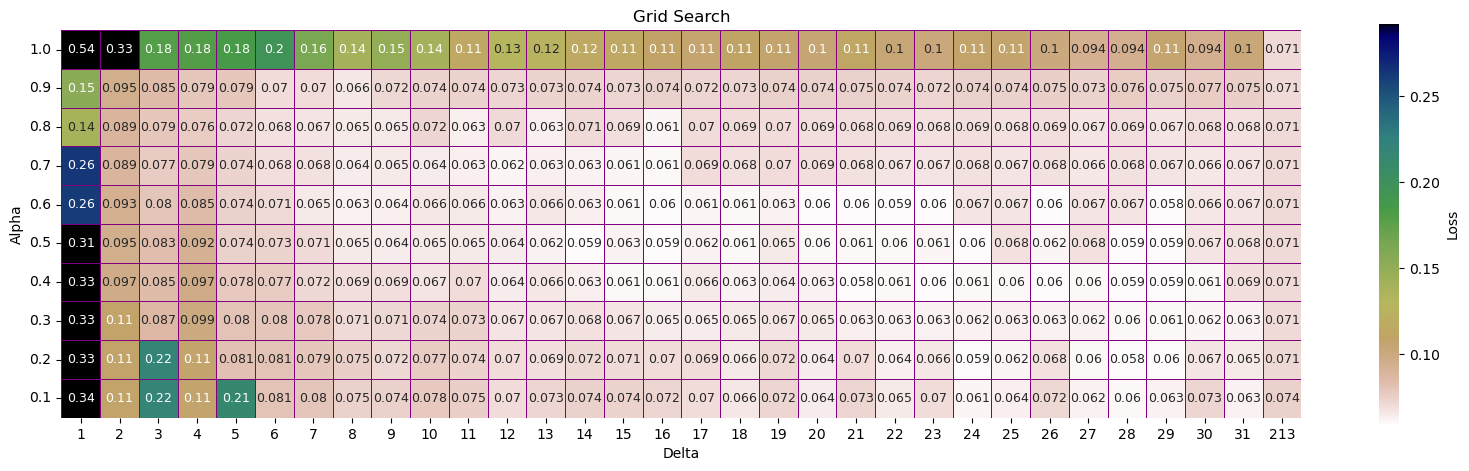

In [23]:
plot_grid_search_heatmap(grid_search_df, annot_size=9, palette="gist_earth")

### Setting the best hyperparameters for training phase

In [24]:
# Show best and worse hyperparameters found
best_hparams = list(evaluated_hparams_df.iloc[0].values)
worse_hparams = list(evaluated_hparams_df.iloc[-1].values)
print(f"Best hyperparameters: α = {best_hparams[0]}, β = {best_hparams[1]}, γ = {best_hparams[2]}, δ = {best_hparams[3]}")
print(f"Worse hyperparameters: α = {worse_hparams[0]}, β = {worse_hparams[1]}, γ = {worse_hparams[2]}, δ = {worse_hparams[3]}")

Best hyperparameters: α = 0.4, β = -1.0, γ = -1.0, δ = 21.0
Worse hyperparameters: α = 1.0, β = -1.0, γ = -1.0, δ = 1.0


In [25]:
# Set the best and the worse hyperparameters for global usage
BEST_ALPHA, BEST_BETA, BEST_GAMMA, BEST_DELTA = best_hparams[:-1]
WORSE_ALPHA, WORSE_BETA, WORSE_GAMMA, WORSE_DELTA = worse_hparams[:-1]

## Training phase

In [26]:
# Baseline (FIB-index)
fib_engine_baseline = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=BEST_ALPHA,
    beta=BEST_BETA,
    gamma=BEST_GAMMA,
    delta=timedelta(days=BEST_DELTA),
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Best hyperparameters (TFIB-index)
tfib_engine_best = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=BEST_ALPHA,
    beta=BEST_BETA,
    gamma=BEST_GAMMA,
    delta=timedelta(days=BEST_DELTA),
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Worse hyperparameters (TFIB-index)
tfib_engine_worse = TFIBEngine(
    reshare_key=lambda x: x[0],
    author_key=lambda x: x[2],
    original_post_key=lambda x: x[3],
    original_author_key=lambda x: x[4],
    timestamp_key=lambda x: x[1],
    flag_key=lambda x: x[5],
    credibility_threshold = CREDIBILITY_THR,
    alpha=WORSE_ALPHA,
    beta=WORSE_BETA,
    gamma=WORSE_GAMMA,
    delta=timedelta(days=WORSE_DELTA),
    use_original_rtt=USE_ORIGINAL_RTT,
    enable_repost_count_scaling=False)

# Create the data for model training
train_set_tuplelist = list(train_set_df.itertuples(index=False))

# Train both models
fib_engine_baseline.fit(train_set_tuplelist) # Baseline
tfib_engine_best.time_fit(train_set_tuplelist) # Proposed (Best settings)
tfib_engine_worse.time_fit(train_set_tuplelist) # Proposed (Worse settings)

In [27]:
# Show FIB-i Top-10 (Baseline)
list(fib_engine_baseline.get_rank().items())[:10]

[('1683455144', 77.0),
 ('245969509', 41.0),
 ('1248216384577953792', 33.0),
 ('1032615842', 32.0),
 ('1322629376421355521', 25.0),
 ('454365633', 24.0),
 ('910827588', 23.0),
 ('1063806444380798976', 20.0),
 ('473801195', 18.0),
 ('1289758279250452480', 14.0)]

In [28]:
# Show TFIB-i Top-10 (Proposed)
list(tfib_engine_best.get_rank().items())[:10]

[('1683455144', 11.689095),
 ('1248216384577953792', 7.6442857),
 ('454365633', 5.6707582),
 ('1032615842', 5.3574233),
 ('500882938', 3.838681),
 ('1241675979929661442', 3.672),
 ('775343030421291008', 3.6285815),
 ('276032034', 2.9531484),
 ('473801195', 2.7563639),
 ('398117986', 2.7284548)]

In [29]:
# Show TFIB-i Top-10 (Proposed)
list(tfib_engine_worse.get_rank().items())[:10]

[('575550577', 3.0),
 ('1683455144', 2.0),
 ('1032615842', 2.0),
 ('104761548', 2.0),
 ('537079214', 2.0),
 ('2513788304', 2.0),
 ('1131151171', 2.0),
 ('741338484', 2.0),
 ('776877146', 2.0),
 ('1277186116823781376', 2.0)]

### Build the Test Ground Truth Ranking

In [30]:
# Build retweet networks from test set (low credibility retweets only)
test_retweets_network = get_retweet_network(
    test_set_df[test_set_df.credibility_score <= CREDIBILITY_THR],
    rt_UserID_col="retweeted_user_id",
    userID_col="user_id",
    rating_col="credibility_score")

# Raw optimal ranking
test_optimal_ranking = get_optimal_ranking(test_retweets_network).set_index("node")

# Conbine the scores to get a single score that keep the ordering
test_optimal_ranking['combined'] = (
    test_optimal_ranking["outgoing_weight"] +
    test_optimal_ranking["incoming_weight"] / 
    (test_optimal_ranking["incoming_weight"].max() + 1))

# Get the optimal ranking as a dict (ground truth)
test_optimal_ranking = test_optimal_ranking.to_dict()["combined"]

In [31]:
# Show optimal ranking Top-10
list(test_optimal_ranking.items())[:10]

[('1683455144', 5380.154545454546),
 ('1248216384577953792', 3010.009090909091),
 ('1241675979929661442', 1158.6090909090908),
 ('1173682089637625856', 881.0),
 ('775343030421291008', 685.0),
 ('1032615842', 551.4454545454546),
 ('874606845511565313', 503.0181818181818),
 ('454365633', 420.0090909090909),
 ('761787475', 420.0090909090909),
 ('1396921468127170567', 410.1)]

## Test Loss

In [32]:
# Evaluate the loss with the test set
FIB_loss_baseline = nDCG_loss(test_optimal_ranking, fib_engine_baseline.get_rank())
TFIB_loss_best = nDCG_loss(test_optimal_ranking, tfib_engine_best.get_rank())
TFIB_loss_worse = nDCG_loss(test_optimal_ranking, tfib_engine_worse.get_rank())

# Show results
print(f"FIB-i Ranking Loss (Baseline): {FIB_loss_baseline}")
print(f"TFIB-i Ranking Loss (Best): {TFIB_loss_best}")
print(f"TFIB-i Ranking Loss (Worse): {TFIB_loss_worse}")

FIB-i Ranking Loss (Baseline): 0.14261661275554138
TFIB-i Ranking Loss (Best): 0.09097312303113414
TFIB-i Ranking Loss (Worse): 0.5392841746569901


## Results dataframe

In [33]:
# Build the results dictionary
test_dismantle_fn = lambda x: network_dismantle(test_retweets_network, x)

results_dict = {
    "FIB-i Baseline": [pair[1] for pair in test_dismantle_fn(fib_engine_baseline.get_rank())],
    f"TFIB-i (α={BEST_ALPHA}, δ={int(BEST_DELTA)})": [pair[1] for pair in test_dismantle_fn(tfib_engine_best.get_rank())],
    f"TFIB-1 (α={WORSE_ALPHA}, δ={int(WORSE_DELTA)})": [pair[1] for pair in test_dismantle_fn(tfib_engine_worse.get_rank())],
    "Optimal": [pair[1] for pair in test_dismantle_fn(test_optimal_ranking)]
}

# Adjust the tracks lenght by replicating the last value
make_lists_same_length(results_dict)

In [34]:
# Convert to dataframe
results_df = pd.DataFrame(results_dict)
results_df.head(10)

,FIB-i Baseline,"TFIB-i (α=0.4, δ=21)","TFIB-1 (α=1.0, δ=1)",Optimal
0,1.000000,1.000000,1.000000,1.000000
1,0.793975,0.793975,0.999962,0.793975
2,0.786969,0.678712,0.793936,0.678712
3,0.671707,0.662634,0.771581,0.634116
4,0.649543,0.640508,0.768633,0.600390
5,0.648662,0.639015,0.768480,0.574168
6,0.632661,0.594419,0.768442,0.552119
7,0.624354,0.568235,0.767446,0.532825
8,0.622976,0.564330,0.767370,0.516786
9,0.615779,0.557134,0.766796,0.500670


## Hyperparameters comparison

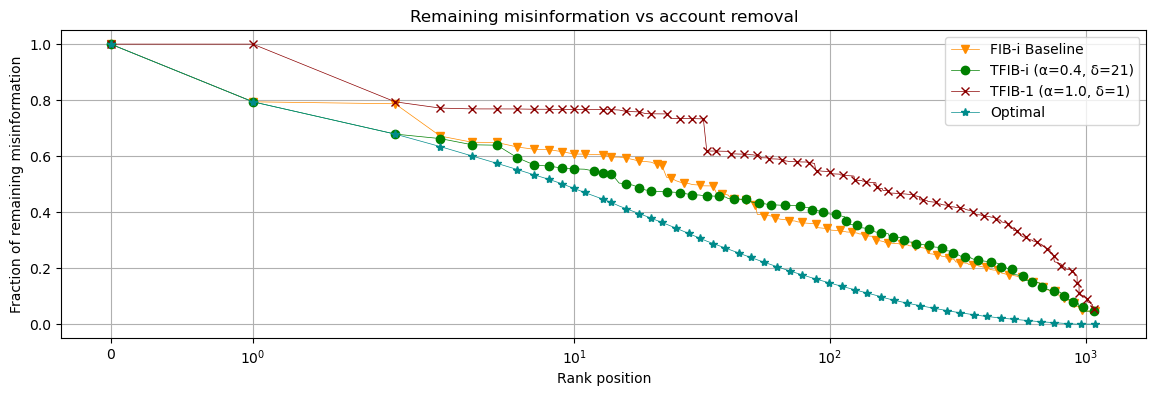

In [35]:
# Set up the plot
colors = ["darkorange", "green", "darkred", "darkcyan"]
styles = ["v-", "o-", "x-" , "*-"]

# Plot
plot_dismantling_graph(results_df, colors, styles)

## Save results

In [36]:
# Your dictionary
training_results = {"Alpha": BEST_ALPHA,
                    "Beta": BEST_BETA,
                    "Gamma": BEST_GAMMA,
                    "Delta": BEST_DELTA,
                    "Ranking": tfib_engine_best.get_rank()}

# Specify the file path
file_path = "data/training_results.pickle"

# Save the dictionary to disk
with open(file_path, 'wb') as f:
    pickle.dump(training_results, f)

## Results Re-Load test

In [37]:
# Load the dictionary from disk
with open(file_path, 'rb') as f:
    loaded_results = pickle.load(f)

import pprint

pprint.pprint(loaded_results, depth=1)

{'Alpha': 0.4, 'Beta': -1.0, 'Delta': 21.0, 'Gamma': -1.0, 'Ranking': {...}}
